In [2]:
import numpy as np
from tsai.all import *
import sklearn.metrics as skm
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import random

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
seed = 1337
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

In [4]:
num_epochs = 100
few_shot_patience = 3

In [5]:
df = pd.read_pickle('togzhan_data_labeled.pkl').reset_index(drop=True)
df['Trial ID'] = df['Person No'].astype(str) + '_' + df['Trial No'].astype(str)

# Load the new doctors data
doctors_df = pd.read_pickle('doctors_data_labeled.pkl').reset_index(drop=True)
doctors_df['Trial ID'] = doctors_df['Person No'].astype(str) + '_' + df['Trial No'].astype(str)

# Create new columns for labels in both datasets
for data in [df, doctors_df]:
    data['Lump'] = data['Type'].apply(lambda x: 1 if x < 9 else 0)

# Split trials into train, validation, and test sets ensuring user independence
unique_persons = df['Person No'].unique()
train_persons, test_persons = train_test_split(unique_persons, test_size=0.1, random_state=seed)
train_persons, valid_persons = train_test_split(train_persons, test_size=0.2, random_state=seed)

train_mask = df['Person No'].isin(train_persons)
valid_mask = df['Person No'].isin(valid_persons)
test_mask = df['Person No'].isin(test_persons)
train_df = df[train_mask]
valid_df = df[valid_mask]
test_df = df[test_mask]

In [6]:
train_mask

0        True
1        True
2        True
3        True
4        True
        ...  
5755    False
5756    False
5757    False
5758    False
5759    False
Name: Person No, Length: 5760, dtype: bool

In [6]:
df

,Person No,Type,Trial No,Data,Label,Trial ID,Lump
0,0,0,0,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...]",1,0_0,1
1,0,0,1,"[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...]",1,0_1,1
2,0,0,2,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...]",1,0_2,1
3,0,0,3,"[1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 3.0, 0.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...]",1,0_3,1
4,0,0,4,"[0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...]",1,0_4,1
...,...,...,...,...,...,...,...
5755,9,12,67,"[1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 5.0, 5.0, 4.0, 4.0, 6.0, 7.0, 7.0, 7.0, 8.0, 8.0, 9.0, 9.0, 8.0, 10.0, 10.0, 9.0, 11.0, 11.0, 11.0, 11.0, 11.0, 12.0, 12.0, 11.0, 12.0, 12.0, 10.0, 10.0, 8.0, 8.0, 8.0, 8.0, 7.0, 7.0, 6.0, 6.0, 6.0, 6.0, 6.0, 4.0, 4.0, 4.0, 5.0, 5.0, 2.0, 3.0, 3.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 3.0, 1.0, 1.0, 2.0, ...]",0,9_67,0
5756,9,12,68,"[1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 4.0, 4.0, 4.0, 5.0, 5.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 8.0, 8.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 10.0, 10.0, 10.0, 9.0, 9.0, 8.0, 8.0, 8.0, 7.0, 7.0, 7.0, 8.0, 8.0, 6.0, 6.0, 5.0, 5.0, 5.0, 4.0, 4.0, 4.0, 2.0, 2.0, 4.0, 2.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...]",0,9_68,0
5757,9,12,69,"[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0

In [5]:
train_df

,Person No,Type,Trial No,Data,Label,Trial ID,Lump
0,0,0,0,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...]",1,0_0,1
1,0,0,1,"[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...]",1,0_1,1
2,0,0,2,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...]",1,0_2,1
3,0,0,3,"[1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 3.0, 0.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...]",1,0_3,1
4,0,0,4,"[0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...]",1,0_4,1
...,...,...,...,...,...,...,...
5467,8,12,67,"[0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 4.0, 4.0, 3.0, 4.0, 4.0, 5.0, 5.0, 3.0, 2.0, 2.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 5.0, 5.0, 6.0, 6.0, ...]",0,8_67,0
5468,8,12,68,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 5.0, 5.0, 5.0, 6.0, 6.0, 7.0, 7.0, 8.0, 8.0, 8.0, 10.0, 9.0, 9.0, 10.0, ...]",0,8_68,0
5469,8,12,69,"[4.0, 4.0, 5.0, 6.0, 6.0, 7.0, 7.0, 7.0, 8.0, 8.0, 9.0, 9.0, 9.0, 10.0, 10.0, 10.0, 11.0, 11.0, 12.0, 11.0, 11.0, 12.0, 12.0, 12.0, 12.0, 12.0, 11.0, 10.0, 10.0, 12.0, 9.0, 9.0, 9.0, 9.0, 9.0, 8.0, 8.0, 8.0, 8.0, 7.0, 7.0,

In [7]:
valid_df

,Person No,Type,Trial No,Data,Label,Trial ID,Lump
2016,7,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 4.0, 4.0, 3.0, 5.0, 5.0, 7.0, 6.0, 6.0, 8.0, 8.0, 7.0, 9.0, 9.0, 9.0, 11.0, 11.0, 10.0, 10.0, ...]",1,7_0,1
2017,7,0,1,"[1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 6.0, 6.0, 6.0, 6.0, 6.0, 7.0, 8.0, 8.0, 6.0, 6.0, 7.0, 8.0, 8.0, 9.0, 9.0, 9.0, 9.0, 9.0, 10.0, 9.0, 9.0, 9.0, 9.0, 9.0, 11.0, 11.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 8.0, 8.0, 8.0, 8.0, 8.0, 6.0, 6.0, 6.0, 7.0, 7.0, 5.0, 4.0, 4.0, 3.0, 1.0, 1.0, 0.0, 0.0, 2.0, 3.0, 3.0, 3.0, ...]",1,7_1,1
2018,7,0,2,"[1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 6.0, 4.0, 4.0, 4.0, 5.0, 5.0, 4.0, 4.0, 5.0, 4.0, 4.0, 5.0, 4.0, 4.0, 5.0, 5.0, 4.0, 2.0, 2.0, 4.0, 3.0, 3.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 0.0, 0.0, 2.0, 2.0, 1.0, 2.0, 2.0, 4.0, 5.0, 5.0, 6.0, 6.0, 7.0, 8.0, 8.0, 9.0, 10.0, 10.0, 10.0, 10.0, 12.0, 10.0, 10.0, 9.0, 7.0, ...]",1,7_2,1
2019,7,0,3,"[0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 0.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 4.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 5.0, 5.0, 5.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 3.0, 3.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, ...]",1,7_3,1
2020,7,0,4,"[1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 3.0, 3.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 2.0, 2.0, 3.0, 3.0, 2.0, 3.0, 3.0, 2.0, 2.0, 3.0, 2.0, 2.0, 1.0, ...]",1,7_4,1
...,...,...,...,...,...,...,...
5755,9,12,67,"[1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 5.0, 5.0, 4.0, 4.0, 6.0, 7.0, 7.0, 7.0, 8.0, 8.0, 9.0, 9.0, 8.0, 10.0, 10.0, 9.0, 11.0, 11.0, 11.0, 11.0, 11.0, 12.0, 12.0, 11.0, 12.0, 12.0, 10.0, 10.0, 8.0, 8.0, 8.0, 8.0, 7.0, 7.0, 6.0, 6.0, 6.0, 6.0, 6.0, 4.0, 4.0, 4.0, 5.0, 5.0, 2.0, 3.0, 3.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 3.0, 1.0, 1.0, 2.0, ...]",0,9_67,0
5756,9,12,68,"[1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 4.0, 4.0, 4.0, 5.0, 5.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 8.0, 8.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 10.0, 10.0, 10.0, 9.0, 9.0, 8.0, 8.0, 8.0, 7.0, 7.0, 7.0, 8.0, 8.0, 6.0, 6.0, 5.0, 5.0, 5.0, 4.0, 4.0, 4.0, 2.0, 2.0, 4.0, 2.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...]",0,9_68,0
5757,9,12,69,"[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.

In [8]:
test_df

,Person No,Type,Trial No,Data,Label,Trial ID,Lump
1728,6,0,0,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...]",1,6_0,1
1729,6,0,1,"[3.0, 3.0, 3.0, 3.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 3.0, 3.0, 4.0, 7.0, 7.0, 10.0, 11.0, 11.0, 11.0, 11.0, 10.0, 11.0, 11.0, 12.0, 16.0, 16.0, 21.0, 21.0, 22.0, 21.0, 21.0, 18.0, 16.0, 16.0, 14.0, 14.0, 16.0, 19.0, 19.0, 22.0, 24.0, 24.0, 25.0, 25.0, 26.0, 29.0, 29.0, 34.0, 41.0, 41.0, 45.0, 45.0, 48.0, 50.0, 50.0, 48.0, 47.0, 47.0, 45.0, 45.0, 44.0, 42.0, 42.0, 41.0, 39.0, 39.0, 37.0, 37.0, 34.0, 28.0, 28.0, 20.0, 17.0, 17.0, 13.0, 13.0, 13.0, 16.0, 16.0, 21.0, 22.0, 22.0, 20.0, 20.0, 19.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 15.0, 15.0, 15.0, 17.0, 17.0, 18.0, 18.0, ...]",1,6_1,1
1730,6,0,2,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, ...]",1,6_2,1
1731,6,0,3,"[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, ...]",1,6_3,1
1732,6,0,4,"[3.0, 2.0, 2.0, 3.0, 3.0, 3.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, ...]",1,6_4,1
...,...,...,...,...,...,...,...
4891,6,12,67,"[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 3.0, 4.0, 4.0, 3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...]",0,6_67,0
4892,6,12,68,"[0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...]",0,6_68,0
4893,6,12,69,"[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0

In [6]:
doctors_df

,Person No,Type,Trial No,Data,Label,Trial ID,Lump
0,0,0,0,"[0.0, 0.0, 1.0, 1.0, 4.0, 0.0, 2.0, 33.0, 5.0, 1.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 4.0, 0.0, 2.0, 33.0, 5.0, 1.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 7.0, 0.0, 0.0, 59.0, 7.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 7.0, 0.0, 0.0, 59.0, 7.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 7.0, 0.0, 0.0, 59.0, 7.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 22.0, 1.0, 0.0, 76.0, 9.0, 0.0, 1.0, 0.0, 1.0, 2.0, 0.0, 0.0, 1.0, 0.0, 1.0, 22.0, 1.0, 0.0, 76.0, 9.0, 0.0, ...]",1,0_0,1
1,0,0,1,"[0.0, 1.0, 1.0, 1.0, 29.0, 0.0, 2.0, 40.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 29.0, 0.0, 2.0, 40.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 29.0, 0.0, 2.0, 40.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 29.0, 0.0, 2.0, 40.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 0.0, 1.0, 59.0, 2.0, 1.0, 1.0, 4.0, 2.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 3.0, 0.0, 1.0, 67.0, 2.0, 0.0, 2.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 3.0, 0.0, 1.0, 67.0, 2.0, 0.0, ...]",1,0_1,1
2,0,0,2,"[0.0, 0.0, 1.0, 1.0, 29.0, 0.0, 0.0, 19.0, 5.0, 0.0, 1.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 29.0, 0.0, 0.0, 19.0, 5.0, 0.0, 1.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 29.0, 0.0, 0.0, 19.0, 5.0, 0.0, 1.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 29.0, 0.0, 0.0, 19.0, 5.0, 0.0, 1.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 32.0, 1.0, 0.0, 24.0, 5.0, 1.0, 0.0, 0.0, 1.0, 0.0, 4.0, 0.0, 0.0, 1.0, 1.0, 32.0, 1.0, 0.0, 24.0, 5.0, 1.0, 0.0, 0.0, 1.0, 0.0, 4.0, 0.0, 0.0, 1.0, 1.0, 32.0, 1.0, 0.0, 24.0, 5.0, 1.0, ...]",1,0_2,1
3,0,0,3,"[0.0, 2.0, 0.0, 0.0, 6.0, 0.0, 1.0, 44.0, 1.0, 0.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 6.0, 0.0, 1.0, 44.0, 1.0, 0.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 6.0, 0.0, 1.0, 44.0, 1.0, 0.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 6.0, 0.0, 0.0, 62.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 2.0, 0.0, 0.0, 6.0, 0.0, 0.0, 62.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 2.0, 0.0, 0.0, 6.0, 0.0, 0.0, 62.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 2.0, 1.0, 0.0, 6.0, 0.0, 0.0, 70.0, 0.0, 0.0, ...]",1,0_3,1
4,0,0,4,"[0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 1.0, 44.0, 0.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 1.0, 44.0, 0.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 1.0, 44.0, 0.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 9.0, 1.0, 0.0, 82.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 2.0, 1.0, 9.0, 1.0, 0.0, 82.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 2.0, 1.0, 9.0, 1.0, 0.0, 82.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 105.0, 1.0, 0.0, ...]",1,0_4,1
...,...,...,...,...,...,...,...
283,0,12,31,"[0.0, 1.0, 1.0, 0.0, 1.0, 6.0, 1.0, 74.0, 4.0, 1.0, 0.0, 20.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 6.0, 1.0, 74.0, 4.0, 1.0, 0.0, 20.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 6.0, 1.0, 74.0, 4.0, 1.0, 0.0, 20.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 2.0, 8.0, 0.0, 122.0, 5.0, 1.0, 1.0, 24.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 2.0, 8.0, 0.0, 122.0, 5.0, 1.0, 1.0, 24.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 2.0, 8.0, 0.0, 122.0, 5.0, 1.0, 1.0, 24.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 3.0, 10.0, 0.0, 171.0, 7.0, 1.0, ...]",0,0_27,0
284,0,12,32,"[0.0, 1.0, 0.0, 1.0, 5.0, 2.0, 1.0, 80.0, 9.0, 0.0, 0.0, 4.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 5.0, 2.0, 1.0, 80.0, 9.0, 0.0, 0.0, 4.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 5.0, 2.0, 1.0, 80.0, 9.0, 0.0, 0.0, 4.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 5.0, 2.0, 1.0, 80.0, 9.0, 0.0, 0.0, 4.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 8.0, 3.0, 0.0, 117.0, 10.0, 0.0, 1.0, 9.0, 0.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 11.0, 4.0, 1.0, 169.0, 11.0, 0.0, 1.0, 9.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 4.0, 1.0, 169.0, 11.0, 0.0, ...]",0,0_28,0
285,0,12,33,"[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 41.0, 1.0, 0.0, 1.0, 12.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 41.0, 1.0, 0.0, 1.0, 12.0, 0.

In [7]:
hashable_columns = [col for col in df.columns if df[col].apply(lambda x: isinstance(x, (str, int, float, bool))).all()]

# Check for duplicate rows within each dataframe
train_duplicates = train_df.duplicated(subset=hashable_columns).sum()
valid_duplicates = valid_df.duplicated(subset=hashable_columns).sum()
test_duplicates = test_df.duplicated(subset=hashable_columns).sum()

# Check for overlapping rows between the dataframes
overlap_train_valid = pd.merge(train_df, valid_df, how='inner', on=hashable_columns)
overlap_train_test = pd.merge(train_df, test_df, how='inner', on=hashable_columns)
overlap_valid_test = pd.merge(valid_df, test_df, how='inner', on=hashable_columns)

print("Duplicate rows in train_df:", train_duplicates)
print("Duplicate rows in valid_df:", valid_duplicates)
print("Duplicate rows in test_df:", test_duplicates)
print("Overlapping rows between train_df and valid_df:", overlap_train_valid.shape[0])
print("Overlapping rows between train_df and test_df:", overlap_train_test.shape[0])
print("Overlapping rows between valid_df and test_df:", overlap_valid_test.shape[0])


Duplicate rows in train_df: 0
Duplicate rows in valid_df: 0
Duplicate rows in test_df: 0
Overlapping rows between train_df and valid_df: 0
Overlapping rows between train_df and test_df: 0
Overlapping rows between valid_df and test_df: 0


In [8]:
def split_sensors(data, sensor_indices, num_seconds):
    data = np.array(data).reshape(-1, 15, 1120)
    selected_data = data[:, sensor_indices, :num_seconds * 160]
    return selected_data

def prepare_lump_datasets(train_df, valid_df, test_df, sensor_indices, num_seconds):
    X_train = np.concatenate([split_sensors(d, sensor_indices, num_seconds) for d in train_df['Data'].values], axis=0)
    y_train_lump = train_df['Lump'].values

    X_valid = np.concatenate([split_sensors(d, sensor_indices, num_seconds) for d in valid_df['Data'].values], axis=0)
    y_valid_lump = valid_df['Lump'].values

    X_test = np.concatenate([split_sensors(d, sensor_indices, num_seconds) for d in test_df['Data'].values], axis=0)
    y_test_lump = test_df['Lump'].values

    return (X_train, y_train_lump), (X_valid, y_valid_lump), (X_test, y_test_lump)

In [21]:
class SingleTaskInceptionTime(nn.Module):
    def __init__(self, input_channels, num_classes_lump):
        super(SingleTaskInceptionTime, self).__init__()
        self.inception_time = InceptionTime(input_channels, 256)  # Adjust the output size
        self.fc_lump = nn.Linear(256, num_classes_lump)

    def forward(self, x):
        x = self.inception_time(x)
        lump_out = self.fc_lump(x)
        return lump_out

def single_task_loss(lump_out, y_lump):
    criterion_lump = nn.CrossEntropyLoss()
    loss_lump = criterion_lump(lump_out, y_lump)
    return loss_lump

def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def train_single_task_model(sensor_indices, num_seconds, train_df, valid_df, test_df, additional_df=None, few_shot_steps=5):
    (X_train, y_train_lump), (X_valid, y_valid_lump), (X_test, y_test_lump) = prepare_lump_datasets(train_df, valid_df, test_df, sensor_indices, num_seconds)
    
    # Prepare the additional dataset if provided
    if additional_df is not None:
        lump_trials = additional_df[additional_df['Lump'] == 1]['Trial ID'].unique()
        no_lump_trials = additional_df[additional_df['Lump'] == 0]['Trial ID'].unique()
        steps = np.arange(1, few_shot_steps + 1)
    else:
        steps = [0]

    # Create DataLoaders
    def create_dataloader(X, y_lump, batch_size=32):
        ds = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y_lump, dtype=torch.long))
        return DataLoader(ds, batch_size=batch_size, shuffle=True)
    
    train_dl = create_dataloader(X_train, y_train_lump)
    valid_dl = create_dataloader(X_valid, y_valid_lump, batch_size=32)
    test_dl = create_dataloader(X_test, y_test_lump, batch_size=32)

    # Define model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SingleTaskInceptionTime(input_channels=X_train.shape[1], num_classes_lump=2)
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs")
        model = nn.DataParallel(model)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Early stopping parameters
    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0
    few_shot_patience_counter = 0
    few_shot_best_val_loss = float('inf')

    train_losses = []
    valid_losses = []

    def train_and_evaluate():
        nonlocal best_val_loss, patience_counter
        for epoch in range(num_epochs):  # Number of epochs
            model.train()
            running_loss = 0.0
            for x_batch, y_batch_lump in tqdm(train_dl, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
                x_batch, y_batch_lump = x_batch.to(device), y_batch_lump.to(device)
                optimizer.zero_grad()
                lump_out = model(x_batch)
                loss = single_task_loss(lump_out, y_batch_lump)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            
            train_losses.append(running_loss / len(train_dl))
            
            # Validation
            model.eval()
            valid_loss = 0.0
            with torch.no_grad():
                for x_batch, y_batch_lump in valid_dl:
                    x_batch, y_batch_lump = x_batch.to(device), y_batch_lump.to(device)
                    lump_out = model(x_batch)
                    loss = single_task_loss(lump_out, y_batch_lump)
                    valid_loss += loss.item()
            
            valid_losses.append(valid_loss / len(valid_dl))

            print(f"Epoch {epoch+1}, Training Loss: {running_loss/len(train_dl):.4f}, Validation Loss: {valid_loss/len(valid_dl):.4f}")

            # Early stopping
            if valid_loss < best_val_loss:
                best_val_loss = valid_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

    def test_model(data_dl):
        model.eval()
        y_true_lump = []
        y_pred_lump = []
        
        with torch.no_grad():
            for x_batch, y_batch_lump in tqdm(data_dl, desc="Testing", leave=False):
                x_batch, y_batch_lump = x_batch.to(device), y_batch_lump.to(device)
                lump_out = model(x_batch)
                _, predicted_lump = torch.max(lump_out, 1)
                
                y_true_lump.extend(y_batch_lump.cpu().tolist())
                y_pred_lump.extend(predicted_lump.cpu().tolist())

        # Calculate metrics
        accuracy_lump = skm.accuracy_score(y_true_lump, y_pred_lump)
        
        print(f"Test Accuracy - Lump: {accuracy_lump:.4f}")
        
        print("\nConfusion Matrix - Lump:")
        cm_lump = confusion_matrix(y_true_lump, y_pred_lump)
        print(cm_lump)
        plot_confusion_matrix(cm_lump, classes=['No Lump', 'Lump'], title='Confusion Matrix - Lump')
        
        print("\nClassification Report - Lump:")
        print(classification_report(y_true_lump, y_pred_lump, target_names=['No Lump', 'Lump']))
        
        return accuracy_lump

    def summarize_results(results):
        summary = pd.DataFrame(results, columns=['Training Phase', 'Lump Accuracy'])
        print(summary.to_markdown(index=False))

    # Initial training and evaluation
    print("Initial Training and Evaluation:")
    train_and_evaluate()
    initial_accuracies = test_model(test_dl)
    results = [('Initial Training', initial_accuracies)]

    # Plotting learning curves
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Learning Curves')
    plt.legend()
    plt.show()

    summarize_results(results)

    return initial_accuracies

In [22]:
sensor_indices = list(range(15))  # Using all 15 sensors
num_seconds = 7  # Using 7 seconds duration

Using 2 GPUs
Initial Training and Evaluation:


Epoch 1, Training Loss: 0.4935, Validation Loss: 0.6014


Epoch 2, Training Loss: 0.4370, Validation Loss: 0.6821


Epoch 3, Training Loss: 0.4089, Validation Loss: 0.5390


Epoch 4, Training Loss: 0.3856, Validation Loss: 0.6694


Epoch 5, Training Loss: 0.3767, Validation Loss: 0.6462


Epoch 6, Training Loss: 0.3539, Validation Loss: 0.9021


Epoch 7, Training Loss: 0.3473, Validation Loss: 0.8020


Epoch 8, Training Loss: 0.3314, Validation Loss: 0.7995
Early stopping at epoch 8


Test Accuracy - Lump: 0.4861

Confusion Matrix - Lump:
[[116 172]
 [124 164]]


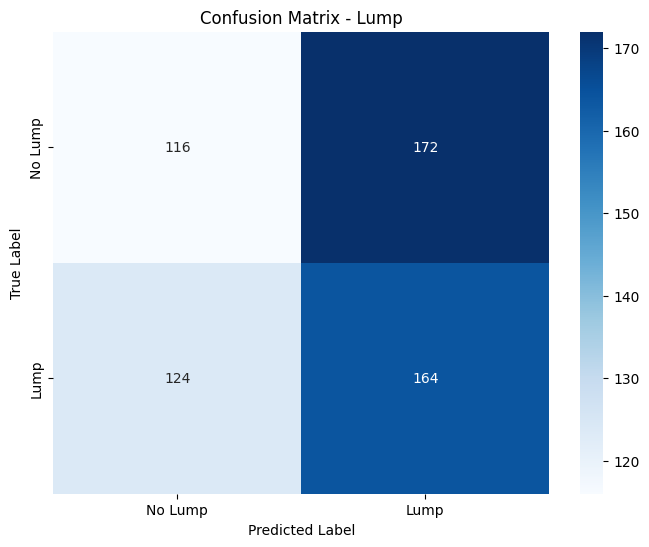


Classification Report - Lump:
              precision    recall  f1-score   support

     No Lump       0.48      0.40      0.44       288
        Lump       0.49      0.57      0.53       288

    accuracy                           0.49       576
   macro avg       0.49      0.49      0.48       576
weighted avg       0.49      0.49      0.48       576



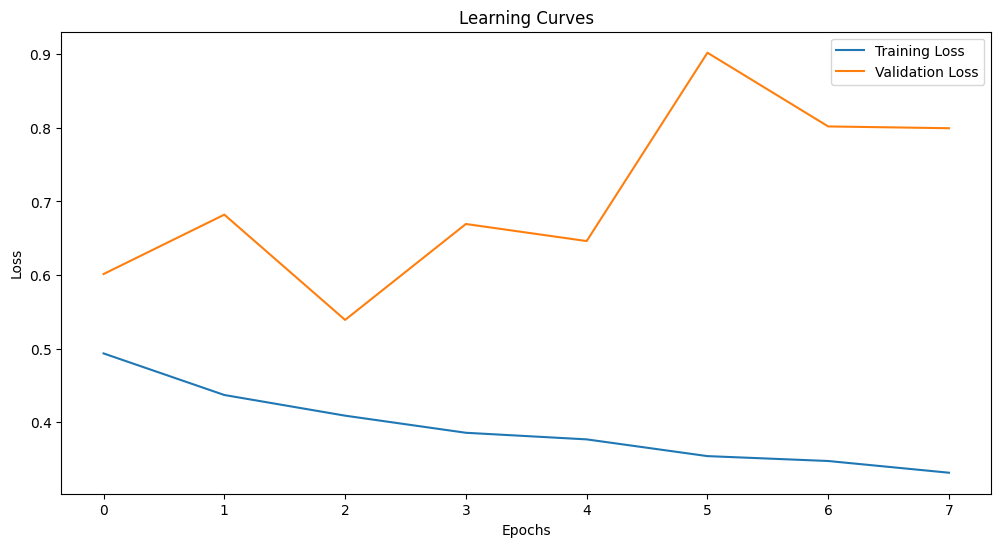

| Training Phase   |   Lump Accuracy |
|:-----------------|----------------:|
| Initial Training |        0.486111 |


In [23]:
initial_accuracies = train_single_task_model(sensor_indices, num_seconds, train_df, valid_df, test_df, additional_df=doctors_df, few_shot_steps=50)